
# Baseline: Sum of 5 Metrics + Inverse Variant (Simple Regressions)

This notebook provides two baselines:

1) **Direct Sum-5**: `helpfulness + correctness + coherence + complexity + verbosity`  
2) **Inverse-Adjusted Sum-5**: `helpfulness + correctness + coherence + (4 - complexity) + (4 - verbosity)`

Both use the same **engineered features** (response + optional prompt relations).  
Models:
- **Ridge** for the direct Sum-5
- **LinearRegression** (ordinary least squares) for the inverse-adjusted Sum-5

Each is evaluated on `validation.csv` with R²/MAE, scatter, and residuals.


In [2]:

# === Cell 1: Config & imports ===
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

TRAIN_PATH = Path("train.csv")
VAL_PATH   = Path("validation.csv")

SEED = 42
np.random.seed(SEED)

assert TRAIN_PATH.exists(), f"Missing {TRAIN_PATH.resolve()}"
assert VAL_PATH.exists(),   f"Missing {VAL_PATH.resolve()}"


In [3]:

# === Cell 2: Lightweight text feature helpers ===
try:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    STOPWORDS = set(ENGLISH_STOP_WORDS)
except Exception:
    STOPWORDS = {"the","a","an","and","or","but","if","then","else","when","while","of","in","on","for","to","from","by","with",
                 "as","at","that","this","these","those","it","its","is","are","was","were","be","been","being","do","does","did",
                 "have","has","had","i","you","he","she","we","they","them","my","your","his","her","our","their","me","us"}

def tokens(text):
    return re.findall(r"[A-Za-z]{2,}", str(text).lower())

def avg_word_len(text):
    toks = tokens(text)
    return (sum(len(t) for t in toks)/len(toks)) if toks else 0.0

def syllable_count(word):
    w = word.lower()
    if not w: return 0
    vowels = "aeiouy"; count, prev = 0, False
    for ch in w:
        v = ch in vowels
        if v and not prev: count += 1
        prev = v
    if w.endswith("e") and count > 1: count -= 1
    return max(1, count)

def flesch_reading_ease(text):
    toks = tokens(text)
    if not toks: return 0.0
    n_words = len(toks)
    n_sents = max(1, len(re.findall(r"[.!?]+", str(text))))
    n_syll  = sum(syllable_count(w) for w in toks)
    return 206.835 - 1.015*(n_words/n_sents) - 84.6*(n_syll/n_words)

VERB_SUFFIXES = ("ing","ed","en","ize","ise","ify")
ADJ_SUFFIXES  = ("ous","ful","ive","less","able","ible","al","ary","ic","ical","y","ish")
NOUN_SUFFIXES = ("tion","sion","ment","ness","ity","ship","ism","ist","ance","ence","ery","or","er")
def is_verbish(tok): return tok.endswith(VERB_SUFFIXES)
def is_adjish(tok):  return tok.endswith(ADJ_SUFFIXES)
def is_nounish(tok): return tok.endswith(NOUN_SUFFIXES)

def pos_counts(text):
    toks = tokens(text)
    v = sum(1 for t in toks if is_verbish(t))
    a = sum(1 for t in toks if is_adjish(t))
    n = sum(1 for t in toks if is_nounish(t))
    return len(toks), v, a, n

def jaccard_overlap(a_text, b_text):
    A = set(t for t in tokens(a_text) if t not in STOPWORDS)
    B = set(t for t in tokens(b_text) if t not in STOPWORDS)
    return (len(A & B) / max(1, len(A | B))) if (A or B) else 0.0

def extract_all(text):
    toks = tokens(text); n_tok = len(toks)
    n_sent = max(1, len(re.findall(r"[.!?]+", str(text))))
    total, v, a, n = pos_counts(text)
    content_toks = [t for t in toks if t not in STOPWORDS]
    lexical_density = (len(content_toks) / n_tok) if n_tok else 0.0
    return {
        "resp_word_len": n_tok,
        "resp_avg_word_len": avg_word_len(text),
        "resp_tokens_per_sentence": (n_tok/n_sent) if n_sent else 0.0,
        "resp_flesch_readability": flesch_reading_ease(text),
        "resp_adj_count": a,
        "resp_verb_ratio": (v/n_tok) if n_tok else 0.0,
        "resp_adj_ratio": (a/n_tok) if n_tok else 0.0,
        "resp_noun_count": n,
        "resp_type_token_ratio": (len(set(toks))/n_tok) if n_tok else 0.0,
        "resp_lexical_density": lexical_density,
        "resp_punct_density": (len(re.findall(r"[,:;—-]", str(text))) / max(1, len(str(text))))
    }

def build_features(df, prompt_col=None, response_col="response"):
    rows = []
    for _, row in df.iterrows():
        rs = str(row[response_col])
        base = extract_all(rs)

        if prompt_col and isinstance(row.get(prompt_col, ""), str):
            pr = str(row[prompt_col])
            ppt = extract_all(pr)
            base.update({
                "pr_word_len": ppt.get("resp_word_len", 0.0),
                "pr_hapax_ratio": ppt.get("resp_type_token_ratio", 0.0),
                "pr_lexical_density": ppt.get("resp_lexical_density", 0.0),
                "pr_punct_density": ppt.get("resp_punct_density", 0.0),
                "prr_len_ratio": (base.get("resp_word_len",0.0)/max(1, len(tokens(pr)))),
                "prr_avg_wordlen_diff": (base.get("resp_avg_word_len",0.0)-avg_word_len(pr)),
                "prr_overlap_jaccard": jaccard_overlap(pr, rs)
            })
        else:
            base.update({
                "pr_word_len":0.0,"pr_hapax_ratio":0.0,"pr_lexical_density":0.0,"pr_punct_density":0.0,
                "prr_len_ratio":0.0,"prr_avg_wordlen_diff":base.get("resp_avg_word_len",0.0),"prr_overlap_jaccard":0.0
            })
        rows.append(base)
    return pd.DataFrame(rows)


In [4]:

# === Cell 3: Train on TRAIN — direct Sum-5 (Ridge) ===
data = pd.read_csv(TRAIN_PATH)

prompt_col_candidates   = ["prompt", "question", "instruction", "input"]
response_col_candidates = ["response", "response_text", "answer", "completion", "output"]
prompt_col   = next((c for c in prompt_col_candidates   if c in data.columns), None)
response_col = next((c for c in response_col_candidates if c in data.columns), None)
assert response_col is not None, f"Could not find a response column in {response_col_candidates}."

five = ["helpfulness","correctness","coherence","complexity","verbosity"]
missing = [c for c in five if c not in data.columns]
assert not missing, f"TRAIN missing required metrics: {missing}"

for c in five:
    data[c] = pd.to_numeric(data[c], errors="coerce")
data["sum5"] = data[five].sum(axis=1, min_count=1)

X = build_features(data, prompt_col=prompt_col, response_col=response_col).astype(float).fillna(0.0)
y = data["sum5"].to_numpy()

ridge_model = make_pipeline(StandardScaler(with_mean=True, with_std=True), Ridge(alpha=1.0, random_state=SEED))
ridge_model.fit(X.values, y)

from pandas import DataFrame
ridge = ridge_model.named_steps["ridge"]
coef_df = DataFrame({"feature": X.columns, "coef": ridge.coef_.astype(float)}).sort_values("coef", ascending=False)
print("Top positive drivers (Ridge / Sum-5):"); display(coef_df.head(12))
print("Top negative drivers (Ridge / Sum-5):"); display(coef_df.tail(12))
print("Feature matrix shape:", X.shape, "| Target length:", len(y))


Top positive drivers (Ridge / Sum-5):


,feature,coef
1,resp_avg_word_len,0.858575
15,prr_len_ratio,0.556990
0,resp_word_len,0.384301
2,resp_tokens_per_sentence,0.376282
3,resp_flesch_readability,0.243405
7,resp_noun_count,0.206486
6,resp_adj_ratio,0.164502
5,resp_verb_ratio,0.144110
17,prr_overlap_jaccard,0.093577
4,resp_adj_count,0.088457


Top negative drivers (Ridge / Sum-5):


,feature,coef
6,resp_adj_ratio,0.164502
5,resp_verb_ratio,0.144110
17,prr_overlap_jaccard,0.093577
4,resp_adj_count,0.088457
11,pr_word_len,0.074096
13,pr_lexical_density,0.060925
14,pr_punct_density,0.055479
10,resp_punct_density,0.029735
16,prr_avg_wordlen_diff,-0.069554
9,resp_lexical_density,-0.296719


Feature matrix shape: (35331, 18) | Target length: 35331


[Ridge / Sum-5] Validation — R²: 0.215 | MAE: 2.211 | n=1789


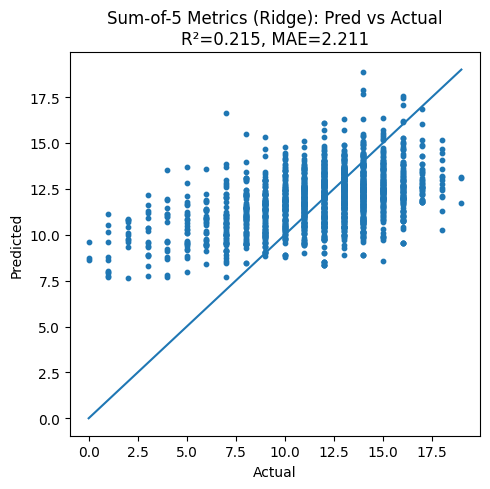

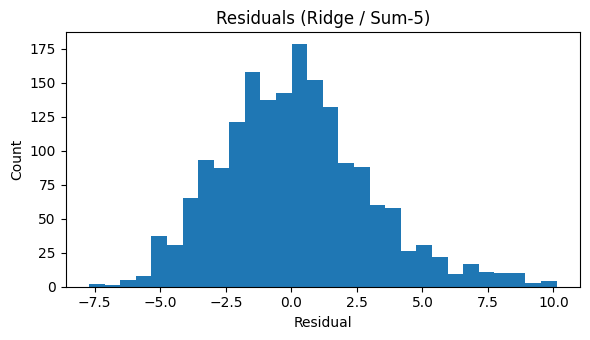

In [5]:

# === Cell 4: Validation — direct Sum-5 (Ridge) ===
df_val = pd.read_csv(VAL_PATH).copy()
val_response_col = response_col if response_col in df_val.columns else (
    "response" if "response" in df_val.columns else ("response_text" if "response_text" in df_val.columns else None)
)
assert val_response_col is not None, "validation.csv must include a response column ('response' or 'response_text')."

missing_v = [c for c in ["helpfulness","correctness","coherence","complexity","verbosity"] if c not in df_val.columns]
assert not missing_v, f"VALIDATION missing required metrics: {missing_v}"

for c in ["helpfulness","correctness","coherence","complexity","verbosity"]:
    df_val[c] = pd.to_numeric(df_val[c], errors="coerce")
df_val["sum5"] = df_val[["helpfulness","correctness","coherence","complexity","verbosity"]].sum(axis=1, min_count=1)

Xv = build_features(df_val, prompt_col=prompt_col if (prompt_col and prompt_col in df_val.columns) else None,
                    response_col=val_response_col).astype(float).fillna(0.0)

for c in X.columns:
    if c not in Xv.columns: Xv[c] = 0.0
Xv = Xv[X.columns].values

y_true = df_val["sum5"].to_numpy()
y_pred = ridge_model.predict(Xv)

mask = np.isfinite(y_true) & np.isfinite(y_pred)
r2  = r2_score(y_true[mask], y_pred[mask])
mae = mean_absolute_error(y_true[mask], y_pred[mask])
print(f"[Ridge / Sum-5] Validation — R²: {r2:.3f} | MAE: {mae:.3f} | n={mask.sum()}")

lo, hi = float(np.min(np.r_[y_true[mask], y_pred[mask]])), float(np.max(np.r_[y_true[mask], y_pred[mask]]))
plt.figure(figsize=(5,5))
plt.scatter(y_true[mask], y_pred[mask], s=10)
plt.plot([lo, hi], [lo, hi])
plt.title(f"Sum-of-5 Metrics (Ridge): Pred vs Actual\nR²={r2:.3f}, MAE={mae:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

resid = (y_pred[mask] - y_true[mask]).astype(float)
plt.figure(figsize=(6,3.5))
plt.hist(resid, bins=30)
plt.title("Residuals (Ridge / Sum-5)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


[OLS / Inverse Sum-5] Validation — R²: 0.078 | MAE: 1.907 | n=1789


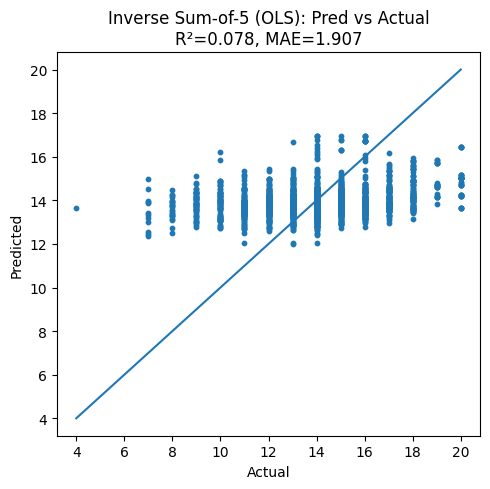

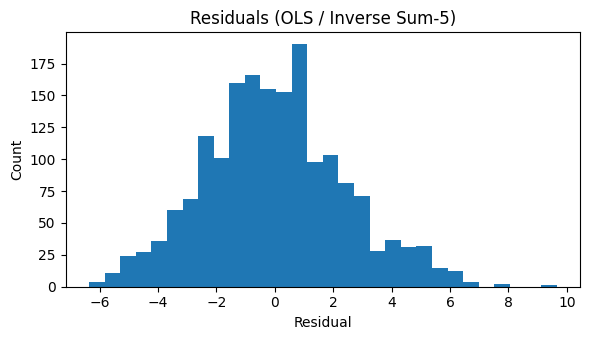

In [6]:

# === Cell 5: Inverse-adjusted Sum-5 (LinearRegression) ===
# Target = helpfulness + correctness + coherence + (4 - complexity) + (4 - verbosity)
data_inv = pd.read_csv(TRAIN_PATH)

for c in ["helpfulness","correctness","coherence","complexity","verbosity"]:
    data_inv[c] = pd.to_numeric(data_inv[c], errors="coerce")
data_inv["complexity_inv"] = 4 - data_inv["complexity"]
data_inv["verbosity_inv"] = 4 - data_inv["verbosity"]
data_inv["sum5_inv"] = data_inv[["helpfulness","correctness","coherence","complexity_inv","verbosity_inv"]].sum(axis=1, min_count=1)

X_inv = build_features(data_inv, prompt_col=prompt_col, response_col=response_col).astype(float).fillna(0.0)
y_inv = data_inv["sum5_inv"].to_numpy()

ols_model = make_pipeline(StandardScaler(with_mean=True, with_std=True), LinearRegression())
ols_model.fit(X_inv.values, y_inv)

# Validate on inverse-adjusted target
df_val_inv = pd.read_csv(VAL_PATH).copy()
for c in ["helpfulness","correctness","coherence","complexity","verbosity"]:
    df_val_inv[c] = pd.to_numeric(df_val_inv[c], errors="coerce")
df_val_inv["complexity_inv"] = 4 - df_val_inv["complexity"]
df_val_inv["verbosity_inv"] = 4 - df_val_inv["verbosity"]
df_val_inv["sum5_inv"] = df_val_inv[["helpfulness","correctness","coherence","complexity_inv","verbosity_inv"]].sum(axis=1, min_count=1)

Xv_inv = build_features(df_val_inv, prompt_col=prompt_col if (prompt_col and prompt_col in df_val_inv.columns) else None,
                        response_col=val_response_col).astype(float).fillna(0.0)
for c in X_inv.columns:
    if c not in Xv_inv.columns: Xv_inv[c] = 0.0
Xv_inv = Xv_inv[X_inv.columns].values

y_true_inv = df_val_inv["sum5_inv"].to_numpy()
y_pred_inv = ols_model.predict(Xv_inv)

mask = np.isfinite(y_true_inv) & np.isfinite(y_pred_inv)
r2i  = r2_score(y_true_inv[mask], y_pred_inv[mask])
mae_i = mean_absolute_error(y_true_inv[mask], y_pred_inv[mask])
print(f"[OLS / Inverse Sum-5] Validation — R²: {r2i:.3f} | MAE: {mae_i:.3f} | n={mask.sum()}")

lo, hi = float(np.min(np.r_[y_true_inv[mask], y_pred_inv[mask]])), float(np.max(np.r_[y_true_inv[mask], y_pred_inv[mask]]))
plt.figure(figsize=(5,5))
plt.scatter(y_true_inv[mask], y_pred_inv[mask], s=10)
plt.plot([lo, hi], [lo, hi])
plt.title(f"Inverse Sum-of-5 (OLS): Pred vs Actual\nR²={r2i:.3f}, MAE={mae_i:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

resid = (y_pred_inv[mask] - y_true_inv[mask]).astype(float)
plt.figure(figsize=(6,3.5))
plt.hist(resid, bins=30)
plt.title("Residuals (OLS / Inverse Sum-5)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()



## Notes
- The **inverse** variant flips the direction of two metrics only; everything else stays identical.
- Use this as a sanity check to see if flipping aligns better with your evaluation convention.
- Next step: small `alpha` sweep for Ridge and compare OLS vs Ridge/ElasticNet.
